## Семинар 6 "Segmentation"

ФИО:Радионов Максим Анатольевич

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 26 апреля 2020). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cp '/content/drive/My Drive/colab_data/neural/train_utils.py' /content/
%cd '/content/drive/My Drive/colab_data/neural/glas'
!cp *.zip /content/
%cd /content
!rm -r test training
!unzip training.zip
!unzip test.zip
!mv training train
!ls

/content/drive/My Drive/colab_data/neural/glas
/content
Archive:  training.zip
   creating: training/
   creating: training/1st_manual/
 extracting: training/1st_manual/21_manual1.gif  
 extracting: training/1st_manual/22_manual1.gif  
 extracting: training/1st_manual/23_manual1.gif  
 extracting: training/1st_manual/24_manual1.gif  
 extracting: training/1st_manual/25_manual1.gif  
 extracting: training/1st_manual/26_manual1.gif  
 extracting: training/1st_manual/27_manual1.gif  
 extracting: training/1st_manual/28_manual1.gif  
 extracting: training/1st_manual/29_manual1.gif  
 extracting: training/1st_manual/30_manual1.gif  
 extracting: training/1st_manual/31_manual1.gif  
 extracting: training/1st_manual/32_manual1.gif  
 extracting: training/1st_manual/33_manual1.gif  
 extracting: training/1st_manual/34_manual1.gif  
 extracting: training/1st_manual/35_manual1.gif  
 extracting: training/1st_manual/36_manual1.gif  
 extracting: training/1st_manual/37_manual1.gif  
 extracting: t

In [ ]:
!pip install pytorch-lightning
!pip install imagecodecs

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy
import scipy.misc
import torch.nn as nn
from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


from PIL import Image
import skimage
import skimage.transform
from skimage import io
import imageio

from random import uniform, choice

from torch.utils.tensorboard import SummaryWriter
TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [ ]:
# %load train_utils.py
# %load train_utils.py                                                          
import numpy as np                                                              
#from sklearn.datasets import fetch_mldata                                      
from sklearn.model_selection import train_test_split                            
import matplotlib.pyplot as plt                                                 
import torch                                                                    
from torch import nn                                                            
from torch.utils.data import DataLoader                                         
from torchvision.datasets import MNIST                                          
from torchvision import transforms                                              
import sys                                                                      
from IPython.display import clear_output                                        
                                                                                
def _epoch(network, loss, loader,                                               
           backward=True,                                                       
           optimizer=None,                                                      
           device='cpu',                                                        
           ravel_init=False):                                                   
    losses = []                                                                 
    accuracies = []                                                             
    if optimizer is not None:
     for param_group in optimizer.param_groups:
      print('lr: ',param_group['lr']) 
    for X, y in loader:                                                         
        X = X.to(device)                                                        
        y = y.to(device)                                                        
        if ravel_init:                                                          
            X = X.view(X.size(0), -1)                                           
        network.zero_grad()                                                     
        prediction = network(X)                                                 
        loss_batch = loss(prediction, y)                                        
        losses.append(loss_batch.cpu().item())                                  
        if backward:                                                            
            loss_batch.backward()                                               
            optimizer.step()                                                    
        #prediction = prediction.max(1)[1]                                       
        #accuracies.append((prediction==y).cpu().float().numpy().mean())         
    return losses, accuracies                                                   


def train(network, train_loader, test_loader,                                   
          epochs, learning_rate, loss=nn.NLLLoss(), ravel_init=False,           
          device='cpu', tolerate_keyboard_interrupt=True):                      
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)        
    train_loss_epochs = []                                                      
    test_loss_epochs = []                                                       
    train_accuracy_epochs = []                                                  
    test_accuracy_epochs = []                                                   
    network = network.to(device)                                                
    try:                                                                        
        for epoch in range(epochs):                                             
            network.train()                                                     
            losses, accuracies = _epoch(network,                                
                                        loss,                                   
                                        train_loader,                           
                                        True,                                   
                                        optimizer,                              
                                        device,                                 
                                        ravel_init)                             
            train_loss_epochs.append(np.mean(losses))                           
            train_accuracy_epochs.append(np.mean(accuracies))                   
            prediction = None
            if test_loader is not None and epoch > 50 and epoch %3 ==0:
              network.eval()                                                      
              # losses, accuracies = _epoch(network,                                
              #                             loss,                                   
              #                             test_loader,                            
              #                             False,                                  
              #                             optimizer,                              
              #                             device,                                 
              #                             ravel_init)                             
                                                                                  
              # test_loss_epochs.append(np.mean(losses))                            
              X = next(iter(test_loader))
              print(X.shape)
              X = X.to(device)                                                        
              network.zero_grad()                                                     
              prediction = network(X)[0][0].data.cpu().numpy()                                                 
              #test_accuracy_epochs.append(np.mean(accuracies))                    
            clear_output(True)                                                  
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], 0,     
                        train_accuracy_epochs[-1], 0))   
            plt.figure(figsize=(20, 10))                                         
            plt.subplot(1, 2, 1)                                                
            plt.plot(train_loss_epochs, label='Train')                          
            plt.plot(test_loss_epochs, label='Test')                            
            plt.xlabel('Epochs', fontsize=16)             
            plt.ylabel('Loss', fontsize=16)                                     
            plt.legend(loc=0, fontsize=16)                                      
            plt.grid()                                                          
            if prediction is not None:
              plt.subplot(1, 2, 2)                                                
              plt.imshow(prediction, label='Train accuracy')             
            # plt.plot(test_loss_epochs, label='Test')                            
            # plt.xlabel('Epochs', fontsize=16)                                   
            # plt.ylabel('Accuracy', fontsize=16)                                 
            # plt.legend(loc=0, fontsize=16)                                      
            # plt.grid()                                                          
            plt.show()                                                          
    except KeyboardInterrupt:                                                   
        if tolerate_keyboard_interrupt:                                         
            pass                                                                
        else:                                                                   
            raise KeyboardInterrupt                                             
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs                                                 


In [ ]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [ ]:
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angle = angles

    def __call__(self, x):
        #angle = random.choice(self.angles)
        return tsf.functional.rotate(x, self.angle)

In [ ]:
import PIL
class Dataset():
    def __init__(self,data,is_validation):
        self.datas = data
        self.is_validation = is_validation
        self.rotate = tsf.RandomRotation(180)
        # self.s_transform = source_transform
        # self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        if not self.is_validation:
          angle =  uniform(* choice([(-10,0), (0,10),(170,180),(-180,-170)]))
          s_trans = tsf.Compose([
              tsf.ToPILImage(),
              MyRotationTransform(angle),
              #tsf.Resize((400,400)),
              tsf.ToTensor(),
              tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
          ]
          )
          t_trans = tsf.Compose([
              tsf.ToPILImage(),
              MyRotationTransform(angle),
              #tsf.Resize((400,400),interpolation=PIL.Image.NEAREST),
              tsf.ToTensor(),]
          )
        else:
          s_trans = tsf.Compose([
              tsf.ToPILImage(),
              #tsf.Resize((400,400)),
              tsf.ToTensor(),
              tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
          ]
          )
          t_trans = tsf.Compose([
              tsf.ToPILImage(),
              #tsf.Resize((400,400),interpolation=PIL.Image.NEAREST),
              tsf.ToTensor(),]
          )

        img = s_trans(img)
        mask = t_trans(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)


In [ ]:
len(train_data)

20

In [ ]:
# img,mask = train_dataset[12]
# plt.subplot(121)
# plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
# plt.subplot(122)
# plt.imshow(mask[0].numpy())

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        torch.nn.init.xavier_normal_(self.conv[0].weight)
        torch.nn.init.xavier_normal_(self.conv[3].weight)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch),
            nn.Dropout(p=0.1),

        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2) # одновременно тут обратный макс пулинг (stride=2)
        torch.nn.init.xavier_normal_(self.up.weight)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 1024)
        self.up1 = up(1024, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 128)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)
      
      
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x

In [ ]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [ ]:
#крос валидация на одной картинке
# for test_idx in range(len(train_data)):
#   print(test_idx)
#   train_dataset = Dataset([pair for i, pair in enumerate(train_data) if i != test_idx], False)
#   train_dataloader = t.utils.data.DataLoader(train_dataset,num_workers=2,batch_size=4)
#   valid_dataloader = t.utils.data.DataLoader(Dataset([train_data[test_idx]], True),batch_size=1)
#   model = UNet(3,1) # Your model here
#   _,_,_,_ = train(model, train_dataloader, valid_dataloader, 20, 0.01, soft_dice_loss,device='cuda')


In [ ]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    #tsf.Resize((400,400)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
])
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = [t.load(path)[2]]
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
test_dataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [ ]:
train_dataset = Dataset(train_data, False)
train_dataloader = t.utils.data.DataLoader(train_dataset,num_workers=2,batch_size=4)
model = UNet(3,1) # Your model here

Epoch 0... (Train/Test) NLL: 0.196/0.000	Accuracy: nan/0.000


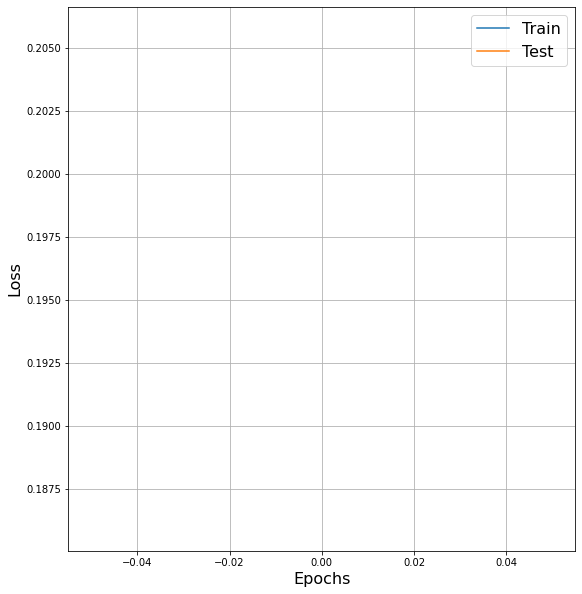

lr:  0.001
CPU times: user 5.54 s, sys: 4.09 s, total: 9.63 s
Wall time: 10 s


In [ ]:
%%time
_,_,_,_ = train(model, train_dataloader, test_dataloader, 400, 0.001, soft_dice_loss,device='cuda')

In [ ]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
test_dataloader = t.utils.data.DataLoader(testset,batch_size=1)

torch.Size([3, 584, 565])


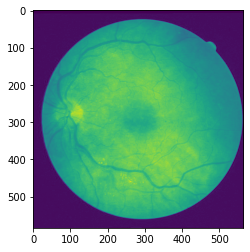

In [ ]:
print(testset[0].shape)
plt.imshow(testset[2][0].data.numpy()*0.5+0.5)

In [ ]:
!rm -r result
!rm  result.zip
os.makedirs("result")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 3, 584, 565])


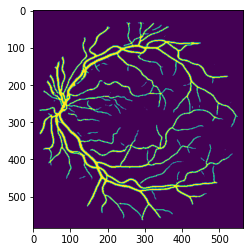

torch.Size([1, 3, 584, 565])


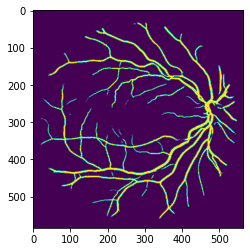

torch.Size([1, 3, 584, 565])


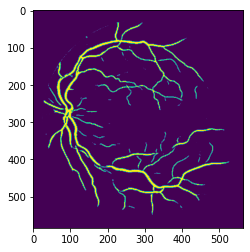

torch.Size([1, 3, 584, 565])


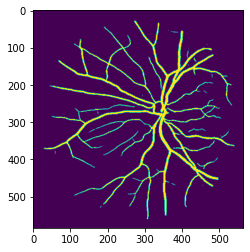

torch.Size([1, 3, 584, 565])


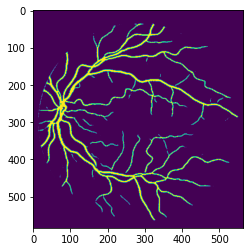

torch.Size([1, 3, 584, 565])


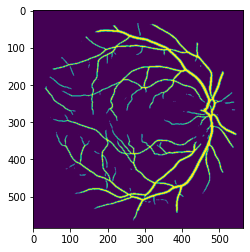

torch.Size([1, 3, 584, 565])


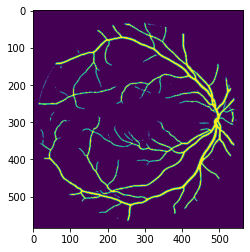

torch.Size([1, 3, 584, 565])


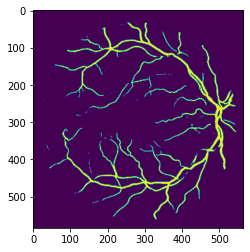

torch.Size([1, 3, 584, 565])


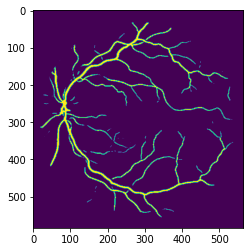

torch.Size([1, 3, 584, 565])


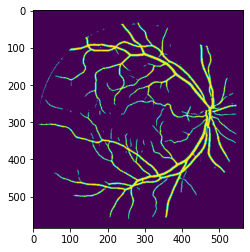

torch.Size([1, 3, 584, 565])


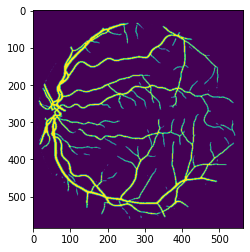

torch.Size([1, 3, 584, 565])


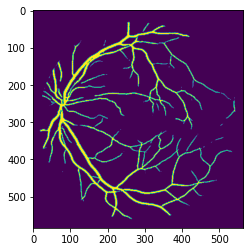

torch.Size([1, 3, 584, 565])


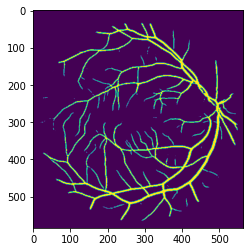

torch.Size([1, 3, 584, 565])


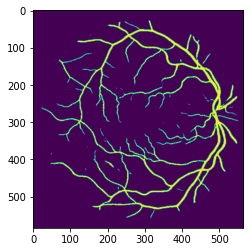

torch.Size([1, 3, 584, 565])


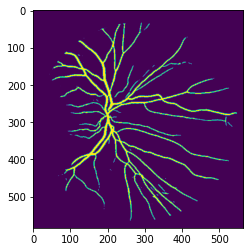

torch.Size([1, 3, 584, 565])


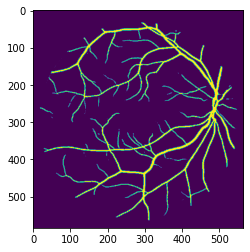

torch.Size([1, 3, 584, 565])


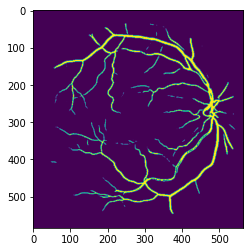

torch.Size([1, 3, 584, 565])


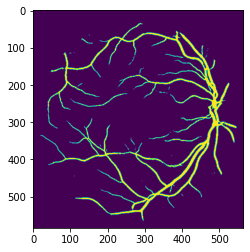

torch.Size([1, 3, 584, 565])


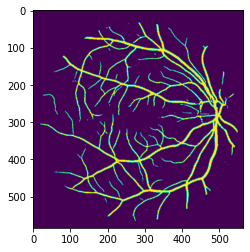

torch.Size([1, 3, 584, 565])


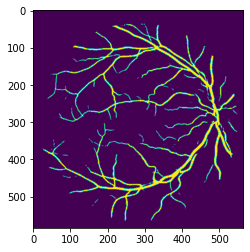

In [ ]:
model = model.eval()
for ex_id, data in enumerate(test_dataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    print(data.shape)
    o = model(data)
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    plt.imshow(tm)
    plt.show()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)

In [ ]:


!zip -r result.zip result

  adding: result/ (stored 0%)
  adding: result/9.png (deflated 1%)
  adding: result/3.png (deflated 1%)
  adding: result/2.png (deflated 1%)
  adding: result/17.png (deflated 1%)
  adding: result/10.png (deflated 1%)
  adding: result/15.png (deflated 1%)
  adding: result/1.png (deflated 1%)
  adding: result/5.png (deflated 1%)
  adding: result/13.png (deflated 1%)
  adding: result/12.png (deflated 1%)
  adding: result/11.png (deflated 1%)
  adding: result/8.png (deflated 1%)
  adding: result/18.png (deflated 1%)
  adding: result/20.png (deflated 1%)
  adding: result/4.png (deflated 1%)
  adding: result/7.png (deflated 1%)
  adding: result/19.png (deflated 1%)
  adding: result/14.png (deflated 1%)
  adding: result/16.png (deflated 1%)
  adding: result/6.png (deflated 1%)


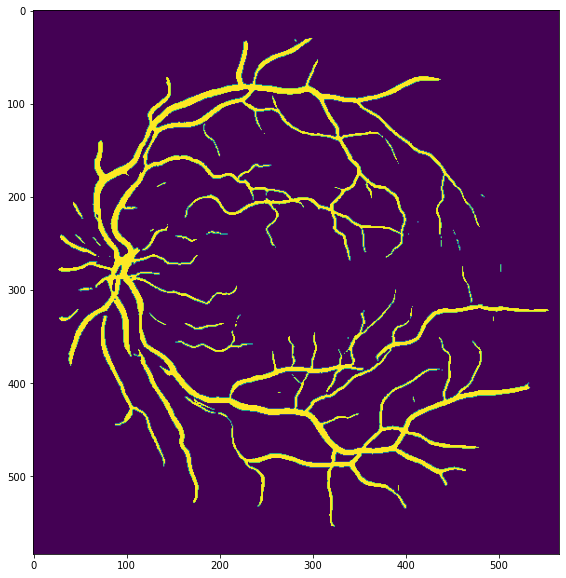

In [ ]:
img = io.imread('result/3.png')
plt.figure(figsize=(20, 10))
plt.imshow(img)

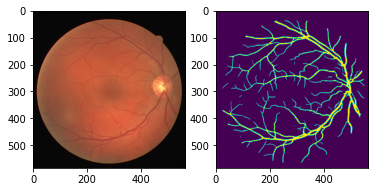

In [ ]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)